# Setup

Load modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import fsolve
from linearmodels import IVSystemGMM, IVGMM

%matplotlib inline
pd.set_option('display.max_columns', None)

Read preprocessed data (data itself can unfortunately not be shared due to licence restrictions)

In [2]:
df = pd.read_pickle('data/preprocessed')

introduce control variables

In [3]:
# introduce control variables

# quarter hours
df['M_15'] = 0
df.loc[df.index.minute == 15,'M_15'] = 1

df['M_30'] = 0
df.loc[df.index.minute == 30,'M_30'] = 1

df['M_45'] = 0
df.loc[df.index.minute == 45,'M_45'] = 1

# hours
for i in ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']:
    df[i] = 0
    df.loc[df.index.hour == int(i),i] = 1

# business days
bdays = pd.bdate_range(df.index.date[1], df.index.date[-1], freq = 'B')
df['Business day'] = 0
for i in bdays:
    df.loc[df.index.date == i, 'Business day'] = 1

#summer / winter  
df['Summer'] = 0
df.loc[(df.index.date > pd.Timestamp('2018-06-20')) & (df.index.date < pd.Timestamp('2018-09-22')),'Summer'] = 1
df.loc[(df.index.date > pd.Timestamp('2019-06-20')) & (df.index.date < pd.Timestamp('2019-09-22')),'Summer'] = 1

df['Winter'] = 0
df.loc[(df.index.date > pd.Timestamp('2018-12-21')) & (df.index.date < pd.Timestamp('2019-03-20')),'Winter'] = 1

define the threshold value for data exclusion (changed in sensitivity analysis)

In [4]:
th = 500
df_short = df.loc[(df['system imbalance'] > th) & (df['ID_coupling'] != 1)]
df_long = df.loc[(df['system imbalance'] < -th) & (df['ID_coupling'] != 1)]
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th)) & (df['ID_coupling'] != 1)]

# Relevance of instruments

testing the relevance of instruments through OLS regressions

In [5]:
def ols_regression(df, endog, exog):       
    model = sm.OLS(df[endog], df[exog])
    results = model.fit()
    print(results.summary())

In [6]:
endog = ['imbalance price']
exog = ['FRR_POS_S', 'FRR_NEG_L', 'const_POS', 'const_NEG']

ols_regression(df_combined, endog, exog)

                            OLS Regression Results                            
Dep. Variable:        imbalance price   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     1549.
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        09:40:44   Log-Likelihood:                -68285.
No. Observations:               11817   AIC:                         1.366e+05
Df Residuals:                   11813   BIC:                         1.366e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FRR_POS_S      0.3328      0.009     38.163      0.0

In [7]:
endog = ['system imbalance']
exog = ['Load DA err', 'Solar DA err', 'Wind ID err', 'ID1-DA', 'const']  

ols_regression(df_combined, endog, exog)

                            OLS Regression Results                            
Dep. Variable:       system imbalance   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2286.
Date:                Tue, 25 Aug 2020   Prob (F-statistic):               0.00
Time:                        09:40:44   Log-Likelihood:                -94460.
No. Observations:               11817   AIC:                         1.889e+05
Df Residuals:                   11812   BIC:                         1.890e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Load DA err     -0.0999      0.003    -31.780   

# Data characteristica

Parameter mean values (Table 2)

In [8]:
for indicator in ['system imbalance', 
                  'imbalance price', 
                  'ID1', 
                  'Load DA err', 
                  'Wind ID err', 
                  'Solar DA err', 
                  'FRR_POS_S', 
                  'FRR_NEG_L',
                  'IGCC']:

    print(indicator)
    print('Mean (short): ' + str(df_short[indicator].mean()))
    print('Mean (long): ' + str(df_long[indicator].mean()))
    print('\n')

system imbalance
Mean (short): 902.5851082668263
Mean (long): -839.5044072642931


imbalance price
Mean (short): 82.72673844300535
Mean (long): 2.909482225656869


ID1
Mean (short): 54.69998795362138
Mean (long): 31.288738408037176


Load DA err
Mean (short): -2028.8555940370427
Mean (long): -755.7063369397218


Wind ID err
Mean (short): 321.71058575515735
Mean (long): -334.91846986089644


Solar DA err
Mean (short): 180.65833458816442
Mean (long): -214.01139876352394


FRR_POS_S
Mean (short): 126.79403122538626
Mean (long): 0.0


FRR_NEG_L
Mean (short): 0.0
Mean (long): 159.5374580260768


IGCC
Mean (short): 195.22898177985297
Mean (long): -158.81409428129865




Create scatter plot of imbalance price and system imbalance (Figure 4)

In [9]:
def scatter_color(df, 
            save_path, 
            y_label='Imbalance price (€/MWh)', 
            x_label='System imbalance (MW)', 
            x='system imbalance', 
            y='imbalance price', 
            xlim=[-3000,3000], 
            xstep=10, 
            ystep=1, 
            ylim=[-300,300], 
            heat=True):
    
    fig = plt.figure(figsize=(6/1.2, 5/1.2))
    
    def get_value(df, x, y):
        try:
            return count.loc[x, y]
        except KeyError:
            return np.nan

    xlist = range(xlim[0], xlim[1]+1, xstep)
    ylist = range(ylim[0], ylim[1]+1, ystep)

    df = df.copy()
    df[x] = (df[x]/xstep).round()*xstep
    df[y] = (df[y]/ystep).round()*ystep

    count = df.groupby([x, y])[x].count().unstack()
    count = pd.concat([
        pd.Series([
            get_value(count, xi, yi)
            for xi in xlist
        ], index=xlist)
        for yi in ylist
    ], axis=1, keys=ylist)

    count = count.div(xstep * ystep)
    
    plt.pcolormesh(count.index, count.columns, count.transpose(), cmap='hot')
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    #Short and long system labels
    props = dict(facecolor='white', alpha=0) 
    fig.text(0.2, 0.93, 'Long system', fontsize=11, verticalalignment='top', bbox=props) 
    fig.text(0.5, 0.93, 'Short system', fontsize=11, verticalalignment='top', bbox=props)
    
    # number of observations
    props = dict(facecolor='white', alpha=1) 
    fig.text(0.56, 0.18, 'N = ' + str(df.shape[0]), fontsize=11, verticalalignment='top', bbox=props) 
    
    # plot colorbar
    #norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(cmap='hot', shrink=0.72, aspect = 20, 
                 ticks=np.arange(0.2,1.66,.2),
                 boundaries=np.arange(.15,1.66,.02))
    
    # colorbarlabel
    props = dict(facecolor='white', alpha=0)
    fig.text(0.78, 0.86, 'Density of\nobservations\n(1 per\nMW * €/MWh)', fontsize=11, verticalalignment='center', 
        horizontalalignment = 'left', bbox=props)
   
    plt.savefig('graphs/' + save_path, dpi = 500)      

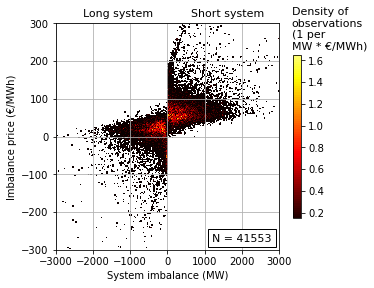

In [10]:
scatter_color(df, save_path='all_data')

# Econometric GMM Model

Define control variables

In [11]:
control_variables = ['Business day', 'Winter', 'Summer', 'M_15','M_30','M_45', '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

Combined system GMM estimation for short and long systems (e.g. Model 1)

In [12]:
def system_GMM_combined(df, wind = 'Wind ID err'):

    demand = ['system imbalance']
    demand_shifters = ['ID1', 'Load DA err', wind, 'Solar DA err']
    supply_instruments = ['Load DA err', 'Solar DA err', wind, 'ID1-DA']
    supply = ['imbalance price']
    supply_shifters = ['IGCC', 'FRR_POS_S', 'FRR_NEG_L'] # 
    demand_instruments = ['FRR_POS_S', 'FRR_NEG_L']

    equations = dict(
        imbalance_price = {
            'dependent': df[supply],
            'exog': df[supply_shifters + ['const_POS', 'const_NEG']], # + control_variables 
            'endog': df[demand],
            'instruments': df[supply_instruments]
        },
        system_imbalance = {
            'dependent': df[demand], 
            'exog': df[demand_shifters + ['const_POS', 'const_NEG']], # + control_variables 
            'endog': df[supply], 
            'instruments': df[supply_shifters]
        }
    )

    system_gmm = IVSystemGMM(equations, weight_type='heteroskedastic')
    results = system_gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [13]:
# Table 3 (1) Combined model
results_combined = system_GMM_combined(df_combined);

Number of iterations: 14
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7783
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 11817   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:03                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
IGCC                -0.0530     0.0064    -8.2259     0.0000     -0.0657

Individual system GMM estimation for short / long systems (e.g. Models 2 and 3)   

In [14]:
def system_GMM_one_direction(df, direction='POS'):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Wind ID err', 'Solar DA err', 'ID1']
    supply_instruments = ['Load DA err', 'Wind ID err', 'Solar DA err', 'ID1-DA']
    supply = ['imbalance price']
    supply_shifters = ['FRR_prices_{}'.format(direction), 'IGCC']
    demand_instruments = ['FRR_prices_{}'.format(direction)]
    
    equations = dict(
        imbalance_price = {
            'dependent': df[supply],
            'exog': df[supply_shifters + ['const']],
            'endog': df[demand],
            'instruments': df[supply_instruments]
        },
        system_imbalance = {
            'dependent': df[demand], 
            'exog': df[demand_shifters + ['const']], 
            'endog': df[supply], 
            'instruments': df[demand_instruments]
        }
    )

    system_gmm = IVSystemGMM(equations, weight_type='heteroskedastic')
    results = system_gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [15]:
# Table 3 (2): short systems (significantly short systems without price coupling)
results_short = system_GMM_one_direction(df_short, 'POS');

Number of iterations: 10
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:             -0.2447
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                  6641   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:03                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_prices_POS       0.3464     0.0680     5.0932     0.0000      0.2131

In [16]:
# Table 3 (3): long system (significantly long systems without price coupling)
results_long = system_GMM_one_direction(df_long, 'NEG');

Number of iterations: 16
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:             -0.0299
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                  5176   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:04                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_prices_NEG      -0.1175     0.0233    -5.0344     0.0000     -0.1633

GMM estimation of the demand curve, i.e. no system of equations, without instruments (Model 4)

In [17]:
def GMM_demand_combined(df):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Solar DA err', 'Wind ID err', 'ID1']
    supply = ['imbalance price']
    supply_shifters = ['FRR_POS_S', 'FRR_NEG_L', 'IGCC']

    dependent = df[demand]
    exog = df[demand_shifters + ['const_POS', 'const_NEG']]
    endog = df[supply]
    instruments = df[supply] # without instruments        

    gmm = IVGMM(dependent, exog, endog, instruments, weight_type='heteroskedastic')
    results = gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [18]:
# [4] whole period (demand)
results_demand_combined = GMM_demand_combined(df_combined);

Number of iterations: 2
                          IV-GMM Estimation Summary                           
Dep. Variable:       system imbalance   R-squared:                      0.8500
Estimator:                     IV-GMM   Adj. R-squared:                 0.8499
No. Observations:               11817   F-statistic:                 5.818e+04
Date:                Tue, Aug 25 2020   P-value (F-stat)                0.0000
Time:                        09:41:06   Distribution:                  chi2(7)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Load DA err        -0.0142     0.0029    -4.8347     0.0000     -0.0200     -0.0084
Solar DA

GMM estimation of the supply curve, i.e. no system of equations, without instruments (Model 5)

In [19]:
def GMM_supply_combined(df):

    demand = ['system imbalance']
    demand_shifters = ['Load DA err', 'Solar DA err', 'Wind ID err', 'ID1']
    supply = ['imbalance price']
    supply_shifters = ['FRR_POS_S', 'FRR_NEG_L', 'IGCC']  
    
    dependent = df[supply]
    exog = df[supply_shifters + ['const_POS', 'const_NEG']]
    endog = df[demand]
    instruments = df[demand] # with instruments: [supply_shifters]
        
    gmm = IVGMM(dependent, exog, endog, instruments, weight_type='heteroskedastic')
    results = gmm.fit(cov_type='kernel', iter_limit=100) # robust
    print('Number of iterations: ' + str(results.iterations))
    print(results)
    
    return(results)

In [20]:
# [5] whole period (supply)
results_supply_combined = GMM_supply_combined(df_combined);

Number of iterations: 2
                          IV-GMM Estimation Summary                           
Dep. Variable:        imbalance price   R-squared:                      0.3306
Estimator:                     IV-GMM   Adj. R-squared:                 0.3303
No. Observations:               11817   F-statistic:                    3433.2
Date:                Tue, Aug 25 2020   P-value (F-stat)                0.0000
Time:                        09:41:08   Distribution:                  chi2(6)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
FRR_POS_S            0.3538     0.1024     3.4551     0.0006      0.1531      0.5545
FRR_

# Estimated supply and demand curve

In [21]:
def scatter_curves(df, df_short, df_long,
            save_path, 
            y_label='Imbalance price (€/MWh)', 
            x_label='System imbalance (MW)', 
            x='system imbalance', 
            y='imbalance price', 
            xlim=[-3000,3000], 
            xstep=10, 
            ystep=1, 
            ylim=[-300,300], 
            heat=True):
    
    fig = plt.figure(figsize=(5/1.2, 5/1.2))
    
    def get_value(df, x, y):
        try:
            return count.loc[x, y]
        except KeyError:
            return np.nan

    xlist = range(xlim[0], xlim[1]+1, xstep)
    ylist = range(ylim[0], ylim[1]+1, ystep)

    df = df.copy()
    df[x] = (df[x]/xstep).round()*xstep
    df[y] = (df[y]/ystep).round()*ystep

    count = df.groupby([x, y])[x].count().unstack()
    count = pd.concat([
        pd.Series([
            get_value(count, xi, yi)
            for xi in xlist
        ], index=xlist)
        for yi in ylist
    ], axis=1, keys=ylist)

    count = count.div(xstep * ystep)
    
    plt.pcolormesh(count.index, count.columns, count.transpose(), cmap='pink')
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    #demand curve (short)
    cx_d = results_combined.params['system_imbalance_const_POS'] + results_combined.params['system_imbalance_Load DA err'] * df_short['Load DA err'].mean() + results_short.params['system_imbalance_Solar DA err'] * df_short['Solar DA err'].mean() + results_short.params['system_imbalance_Wind ID err'] * df_short['Wind ID err'].mean() + results_short.params['system_imbalance_ID1'] * df_short['ID1'].mean()

    c_d = (1 / results_combined.params['system_imbalance_imbalance price']) * (-cx_d)
    x_d_s = np.arange(500,3001, 500)
    y_d_s = (1 / results_combined.params['system_imbalance_imbalance price']) * x_d_s + c_d

    #supply cuve (short)
    c_s = results_combined.params['imbalance_price_const_POS'] + results_combined.params['imbalance_price_FRR_POS_S'] * df_short['FRR_POS_S'].mean()
    x_s_s = np.arange(500,3001, 500)
    y_s_s = results_combined.params['imbalance_price_system imbalance'] * x_s_s + c_s

    #demand curve (long)
    df_long = df.loc[df['system imbalance'] < -500]
    cx_d = results_combined.params['system_imbalance_const_NEG'] + results_combined.params['system_imbalance_Load DA err'] * df_long['Load DA err'].mean() + results_long.params['system_imbalance_Solar DA err'] * df_long['Solar DA err'].mean() + results_long.params['system_imbalance_Wind ID err'] * df_long['Wind ID err'].mean() + results_long.params['system_imbalance_ID1'] * df_long['ID1'].mean()

    c_d = (1 / results_combined.params['system_imbalance_imbalance price']) * (-cx_d)
    x_d_l = np.arange(-3000,0, 500)
    y_d_l = (1 / results_combined.params['system_imbalance_imbalance price']) * x_d_l + c_d

    #supply cuve (long)
    c_s = results_combined.params['imbalance_price_const_NEG'] + results_combined.params['imbalance_price_FRR_NEG_L'] * df_long['FRR_NEG_L'].mean()
    x_s_l = np.arange(-3000,0, 500)
    y_s_l = results_combined.params['imbalance_price_system imbalance'] * x_s_l + c_s

    #plot curves
    plt.plot(x_s_s,y_s_s, color = '#5B9BD5')
    plt.plot(x_s_s,y_d_s, color = '#C40022')
    plt.plot(x_s_l,y_s_l, color = '#5B9BD5')
    plt.plot(x_d_l,y_d_l, color = '#C40022')
    plt.xlim(xlim);
    plt.ylim(ylim);
    
    #Short and long system labels
    #Short and long system labels
    props = dict(facecolor='white', alpha=0) 
    fig.text(0.25, 0.925, 'Long system', fontsize=11, verticalalignment='top', bbox=props) 
    fig.text(0.64, 0.925, 'Short system', fontsize=11, verticalalignment='top', bbox=props)
  

    plt.savefig('graphs/' + save_path, dpi = 500)      

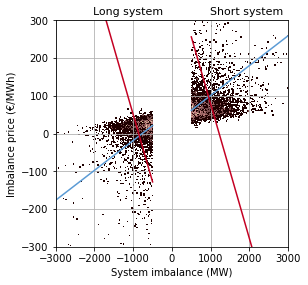

In [22]:
scatter_curves(df.loc[
                    (df['ID_coupling'] != 1) & 
                    ((df['system imbalance'] > th) | (df['system imbalance'] < -th))
                    ],
               df_short,
               df_long,
               save_path='Estimated_curves')

# Quantifying the impact of strategic deviations

Calculation for short systems

In [23]:
# number of perverse incentives
imbalance_price_spread_short = df_short['imbalance price'] - df_short['ID1']

print('Probabily of perverse incentives in short systems in analyzed period:')
perverse_incentives_s = imbalance_price_spread_short[imbalance_price_spread_short < 0].count() / imbalance_price_spread_short.count()
print(round(perverse_incentives_s,3))

Probabily of perverse incentives in short systems in analyzed period:
0.097


Duration curve of the effect of strategic deviations on the system imbalance (short systems)

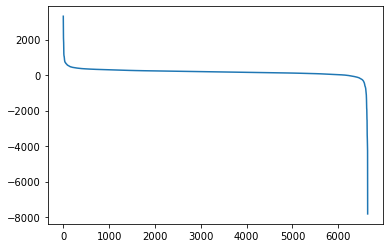

In [24]:
var_strategic_deviations_short = (
    df_short['imbalance price']*results_combined.params['system_imbalance_imbalance price'] + 
    df_short['ID1']*results_combined.params['system_imbalance_ID1']
)
duration_curve_short_w_o_const = pd.Series(var_strategic_deviations_short.sort_values(ascending=False).values)
duration_curve_short_w_o_const.plot()

const_strategic_deviations_short = duration_curve_short_w_o_const.iloc[imbalance_price_spread_short[imbalance_price_spread_short < 0].count()]
strategic_deviations_short = var_strategic_deviations_short - const_strategic_deviations_short

In [25]:
print('Average effect on system imbalance')
print(strategic_deviations_short[strategic_deviations_short>0].mean())
print(strategic_deviations_short[strategic_deviations_short<0].mean())
print(strategic_deviations_short.mean())
print('\n')

print('Average imbalance price spread')
print(imbalance_price_spread_short[imbalance_price_spread_short<0].mean())
print(imbalance_price_spread_short[imbalance_price_spread_short>0].mean())

Average effect on system imbalance
136.62609555368007
-193.81662445366067
-161.8925768480049


Average imbalance price spread
-10.396677067082681
32.13700950158367


Long systems

In [26]:
# number of perverse incentives
imbalance_price_spread_long = df_long['imbalance price'] - df_long['ID1']
print('Probabily of perverse incentives in short systems in analyzed period:')
perverse_incentives_l = imbalance_price_spread_long[imbalance_price_spread_long > 0].count() / imbalance_price_spread_long.count()
print(round(perverse_incentives_l,3))

Probabily of perverse incentives in short systems in analyzed period:
0.093


Duration curve of the effect of strategic deviations on the system imbalance (long systems)

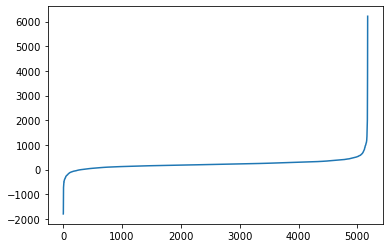

In [27]:
var_strategic_deviations_long = (
    df_long['imbalance price']*results_combined.params['system_imbalance_imbalance price'] + 
    df_long['ID1']*results_combined.params['system_imbalance_ID1']
)
duration_curve_long_w_o_const = pd.Series(var_strategic_deviations_long.sort_values(ascending=True).values)
duration_curve_long_w_o_const.plot()

In [28]:
const_strategic_deviations_long = duration_curve_long_w_o_const.iloc[imbalance_price_spread_long[imbalance_price_spread_long > 0].count()]
strategic_deviations_long = var_strategic_deviations_long - const_strategic_deviations_long

In [29]:
print('Average effect on system imbalance')
print(strategic_deviations_long[strategic_deviations_long<0].mean())
print(strategic_deviations_long[strategic_deviations_long>0].mean())
print(strategic_deviations_long.mean())
print('\n')

print('Average imbalance price spread')
print(imbalance_price_spread_long[imbalance_price_spread_long>0].mean())
print(imbalance_price_spread_long[imbalance_price_spread_long<0].mean())

Average effect on system imbalance
-133.5707079755564
203.8394408613174
172.31452947625735


Average imbalance price spread
10.494202898550743
-32.380083102493096


# Effect of strategic deviations on the peak activation of reserves

In [30]:
system_imbalance_without_SD_long = df_long['system imbalance'] - strategic_deviations_long
print('Long system')
print('observed (including SD)')
print(df_long['system imbalance'].min())
print('\n')
print('Hypothetical (no SD)')
print(system_imbalance_without_SD_long.min())

Long system
observed (including SD)
-3417.244


Hypothetical (no SD)
-7403.105509541781


In [31]:
system_imbalance_without_SD_long.sort_values().head()

2019-08-10 18:00:00+02:00   -7403.105510
2019-07-31 15:15:00+02:00   -5998.809078
2019-09-02 02:45:00+02:00   -5129.590103
2019-09-06 10:45:00+02:00   -4551.906068
2018-12-21 18:30:00+01:00   -3544.009743
dtype: float64

In [32]:
system_imbalance_without_SD_short = df_short['system imbalance'] - strategic_deviations_short

print('Short system')
print('observed (including SD)')
print(df_short['system imbalance'].max())
print('\n')
print('Hypothetical (no SD)')
print(system_imbalance_without_SD_short.max())

Short system
observed (including SD)
8068.064


Hypothetical (no SD)
10362.250248025093


In [33]:
system_imbalance_without_SD_short.sort_values().tail()

2019-06-12 11:45:00+02:00     6140.328503
2019-06-12 11:15:00+02:00     6374.002925
2018-08-08 06:30:00+02:00     6952.039666
2019-06-12 11:30:00+02:00     7190.980315
2019-08-10 10:00:00+02:00    10362.250248
dtype: float64

# Scatter plot visualizing the no-effect-of-strategic-deviations-line

In [34]:
def scatter_id1(df, 
            save_path, 
            xlim=[-50,150], 
            ylim=[0,200],
            x_label='Intraday price (€/MWh)', 
            y_label='Imbalance price (€/MWh)', 
            x='ID1', 
            y='imbalance price'):
    
    fig = plt.figure(figsize=(4.5, 4.5))
    
  
    plt.scatter(df[x],df[y], s = 1)
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
   
    plt.xlim(xlim);
    plt.ylim(ylim);
    
    plt.plot(xlim, xlim, color = 'black', linewidth = 0.5)
    plt.tight_layout()
    plt.savefig('graphs/' + save_path)      

In [35]:
slope = results_combined.params['system_imbalance_ID1'] / results_combined.params['system_imbalance_imbalance price']

In [36]:
def smaller_short(n):
    df = df_short
    share = perverse_incentives_s
    
    return(share - (sum(df['imbalance price'] < df['ID1'] * -slope + n) / (sum(df['imbalance price'] < df['ID1'] * -slope + n) + sum(df['imbalance price'] > df['ID1'] * -slope + n))))

In [37]:
def smaller_long(n):
    df = df_long
    share = 1-perverse_incentives_l
    
    return(share - (sum(df['imbalance price'] < df['ID1'] * -slope + n) / (sum(df['imbalance price'] < df['ID1'] * -slope + n) + sum(df['imbalance price'] > df['ID1'] * -slope + n))))

In [38]:
n_short = fsolve(smaller_short, -100)[0]
n_long = fsolve(smaller_long, -3)[0]

In [39]:
def s_func_x(x):
    return(x * -slope + n_short)
    
def s_func_y(y):
    return((y - n_short) / -slope) 

In [40]:
def l_func_x(x):
    return(x * -slope + n_long)
    
    
def l_func_y(y):
    return((y - n_long) / -slope) 

Graph for short system

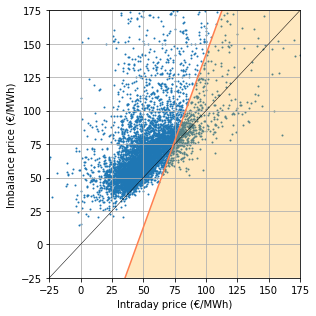

In [41]:
xlim=[-25,175]
ylim=[-25,175]

scatter_id1(df.loc[(df['ID_coupling'] != 1) & (df['system imbalance'] > 500)], 
            save_path='ID1_scatter_short', 
            xlim=xlim,
            ylim=ylim)

x = np.array([-25,175]);
y = s_func_x(x)
plt.plot(x,y, color = 'coral')

points =  [[xlim[1],ylim[1]],[xlim[1],ylim[0]], [s_func_y(ylim[0]),ylim[0]], [s_func_y(ylim[1]),ylim[1]]]
polygon = plt.Polygon(points, fc = 'orange', alpha = 0.25)
plt.gca().add_patch(polygon)

plt.savefig('graphs/' + 'Effect_price_change_short') 

Graph for long system

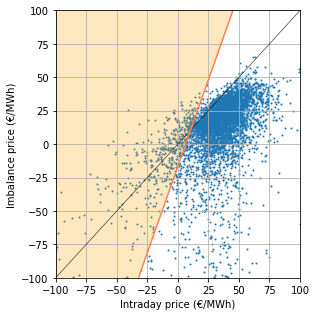

In [42]:
xlim=[-100,100]
ylim=[-100,100]
    
scatter_id1(df.loc[(df['ID_coupling'] != 1) & (df['system imbalance'] < -500)],
            save_path='ID1_scatter_long',
            xlim=xlim,
            ylim=ylim)

x = np.array([-100,100]);
y = l_func_x(x)
plt.plot(x,y, color = 'coral')

points =  [[xlim[0], ylim[1]],[l_func_y(ylim[1]),ylim[1]], [l_func_y(ylim[0]),ylim[0]], [xlim[0],ylim[0]]]
polygon = plt.Polygon(points, fc = 'orange', alpha = 0.25)
plt.gca().add_patch(polygon)

plt.savefig('graphs/' + 'Effect_price_change_long')

# Effect of a 20 €/MWh price change on the system imbalance

In [43]:
print('ID1 change (short):')

print(str(20* results_combined.params['system_imbalance_ID1']), '\n')

print('Imbalance price change (short):')

print(str(20* results_combined.params['system_imbalance_imbalance price']), '\n')

print('ID1 change (long):')

print(str(20* results_combined.params['system_imbalance_ID1']), '\n')

print('Imbalance price change (long):')

print(str(20* results_combined.params['system_imbalance_imbalance price']))

ID1 change (short):
145.17364427934316 

Imbalance price change (short):
-56.10950438023245 

ID1 change (long):
145.17364427934316 

Imbalance price change (long):
-56.10950438023245


#  Sensitivities

In [44]:
#DA wind error
system_GMM_combined(df_combined, wind = 'Wind DA err');

Number of iterations: 86
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7847
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 11817   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:34                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
IGCC                -0.0523     0.0064    -8.2185     0.0000     -0.0648

In [45]:
th = 400
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th)) & (df['ID_coupling'] != 1)]

In [46]:
system_GMM_combined(df_combined);

Number of iterations: 14
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.7195
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 15112   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:35                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
IGCC                -0.0570     0.0060    -9.5289     0.0000     -0.0687

In [47]:
th = 300
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th)) & (df['ID_coupling'] != 1)]

In [48]:
system_GMM_combined(df_combined);

Number of iterations: 23
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.6013
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 19147   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:36                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
IGCC                -0.0635     0.0062    -10.279     0.0000     -0.0756

In [49]:
th = 200
df_combined = df.loc[((df['system imbalance'] < -th) | (df['system imbalance'] > th)) & (df['ID_coupling'] != 1)]

In [50]:
system_GMM_combined(df_combined);

Number of iterations: 24
                 System Iterative System GMM Estimation Summary                 
Estimator:         Iterative System GMM   Overall R-squared:              0.4249
No. Equations.:                       2   Cov. Estimator:                 kernel
No. Observations:                 23976   Num. Constraints:                 None
Date:                  Tue, Aug 25 2020                                         
Time:                          09:41:37                                         
                                                                                
                                                                                
           Equation: imbalance_price, Dependent Variable: imbalance price           
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
IGCC                -0.0702     0.0067    -10.548     0.0000     -0.0832